### Uploading the CSV files

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys(): print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving train_bodies.csv to train_bodies.csv
Saving train_stances.csv to train_stances.csv
User uploaded file "train_bodies.csv" with length 3790028 bytes
User uploaded file "train_stances.csv" with length 4305273 bytes


### Reading from CSV

In [4]:
import pandas as pd
import numpy as np

df_train_stances = pd.read_csv('train_stances.csv')
df_train_bodies = pd.read_csv('train_bodies.csv')

stance = df_train_stances['Stance'].values
print(df_train_stances)
print(df_train_bodies)

                                                Headline  Body ID     Stance
0      Police find mass graves with at least '15 bodi...      712  unrelated
1      Hundreds of Palestinians flee floods in Gaza a...      158      agree
2      Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3      HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4      Spider burrowed through tourist's stomach and ...     1923   disagree
5      'Nasa Confirms Earth Will Experience 6 Days of...      154      agree
6      Accused Boston Marathon Bomber Severely Injure...      962  unrelated
7      Identity of ISIS terrorist known as 'Jihadi Jo...     2033  unrelated
8      Banksy 'Arrested & Real Identity Revealed' Is ...     1739      agree
9          British Aid Worker Confirmed Murdered By ISIS      882  unrelated
10                                        Gateway Pundit     2327    discuss
11     Woman detained in Lebanon is not al-Baghdadi's...     1468      agree

In [5]:
df_train_stances['Body ID'] = df_train_stances['Body ID'].map(df_train_bodies.set_index('Body ID')['articleBody'])
df_train_stances['text'] = df_train_stances['Headline'] + ' ' + df_train_stances['Body ID']

df_train_stances.head()

,Headline,Body ID,Stance,text
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\r\n...,unrelated,Police find mass graves with at least '15 bodi...
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree,Hundreds of Palestinians flee floods in Gaza a...
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated,"Christian Bale passes on role of Steve Jobs, a..."
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated,HBO and Apple in Talks for $15/Month Apple TV ...
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",disagree,Spider burrowed through tourist's stomach and ...


['unrelated' 'agree' 'disagree' 'discuss']
36545 3678 840 8909


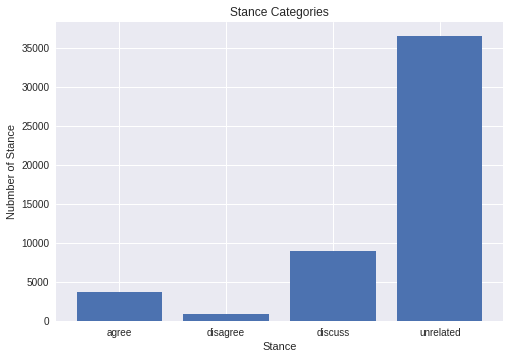

In [6]:
agree = 0
unrelated = 0
disagree = 0
discuss = 0

print(df_train_stances['Stance'].unique())

for stance in df_train_stances['Stance']:
  if stance == 'agree':
    agree += 1
  elif stance == 'disagree':
    disagree += 1
  elif stance == 'unrelated':
    unrelated += 1
  else:
    discuss += 1

print(unrelated, agree, disagree, discuss)

import matplotlib.pyplot as plt

categories = ['unrelated', 'agree', 'disagree', 'discuss']
index = np.arange(len(categories))
values = [36545, 3678, 840, 8909]

plt.bar(categories, values)
plt.title('Stance Categories')
plt.xlabel('Stance')
plt.ylabel('Nubmber of Stance')
plt.show()

## Preprocessing

In [6]:
!pip install -q inflect
!pip install progressbar2
import inflect
import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import progressbar

text = df_train_stances['text'].values

def remove_non_ascii(words):
  """Remove non-ASCII characters from list of tokenized words"""
  str = ''
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    str += new_word
  return str

def remove_punctuation(words):
  """Remove punctuation from list of tokenized words"""
  str = ''
  for word in words:
    new_word = re.sub(r'[^\w\s]', '', word)
    if new_word != '':
      str += new_word
  return str

def replace_numbers(words):
  """Replace all interger occurrences in list of tokenized words with textual representation"""
  p = inflect.engine()
  str = ''
  for word in words:
    if word.isdigit():
      new_word = p.number_to_words(word)
      str += new_word
    else:
      str += word
  return str

def stemming(words):
  str = ''
  stemmer = SnowballStemmer("english")

  for word in words:
    stem = stemmer.stem(word)
    str += stem
  return str

def normalize(words):
  words = remove_non_ascii(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
#   words = stemming(words)
  return words


In [7]:
normalized_text = []

for sentence in progressbar.progressbar(text):
  normalized_sentence = normalize(sentence)
  normalized_text.append(normalized_sentence)


100% (49972 of 49972) |##################| Elapsed Time: 0:04:04 Time:  0:04:04


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english', analyzer='word', lowercase=True, ngram_range=(2, 2))

text_count = count_vect.fit_transform(normalized_text)
print(text_count.shape)
# print(text_count)

(49972, 236304)


In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

text_tfidf = tfidf_transformer.fit_transform(text_count)
print(text_tfidf.shape)
# print(text_tfidf)

(49972, 236304)


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_tfidf, stance, random_state=0, test_size=0.20)

# MultinomialNB

In [29]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

predicted = clf.predict(X_test)
# print(np.mean(predicted == stance))
print('Accuracy of MNB classifier on training set: {:.4f}' .format(clf.score(X_train, y_train)))
print('Accuracy of MNB classifier on test set: {:.4f}' .format(clf.score(X_test, y_test)))

Accuracy of MNB classifier on training set: 0.7937
Accuracy of MNB classifier on test set: 0.7711


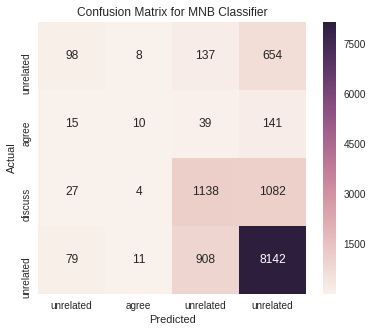

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = stance, yticklabels = stance)
plt.title('Confusion Matrix for MNB Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))
print('Confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

  unrelated       0.45      0.11      0.18       897
      agree       0.30      0.05      0.08       205
   disagree       0.51      0.51      0.51      2251
    discuss       0.81      0.89      0.85      9140

avg / total       0.72      0.75      0.73     12493

Confusion matrix
[[  98    8  137  654]
 [  15   10   39  141]
 [  27    4 1138 1082]
 [  79   11  908 8142]]


# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

predicted = logreg.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.4f}' .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}' .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.8285
Accuracy of Logistic regression classifier on test set: 0.8113


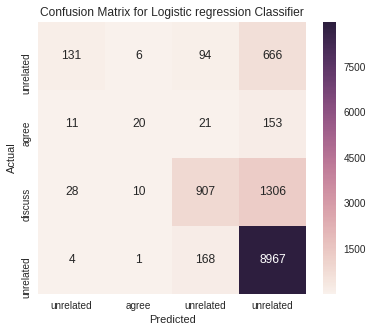

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = stance, yticklabels = stance)
plt.title('Confusion Matrix for Logistic regression Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

             precision    recall  f1-score   support

  unrelated       0.75      0.15      0.24       897
      agree       0.54      0.10      0.17       205
   disagree       0.76      0.40      0.53      2251
    discuss       0.81      0.98      0.89      9140

avg / total       0.79      0.80      0.76     12493



# SVM

In [15]:
from sklearn import svm

svc = svm.SVC(kernel = 'linear', C = 1.0).fit(X_train, y_train)

print('Accuracy of SVM on training set: {:.4f}' .format(svc.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.4f}' .format(svc.score(X_test, y_test)))

Accuracy of SVM on training set: 0.8339
Accuracy of SVM on test set: 0.8170


# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='perceptron', penalty='l2', n_jobs=-1, max_iter=1000, warm_start=True, verbose=True).fit(X_train, y_train)

print('Accuracy of SGD on training set: {:.4f}' .format(sgd.score(X_train, y_train)))
print('Accuracy of SGD on test set: {:.4f}' .format(sgd.score(X_test, y_test)))

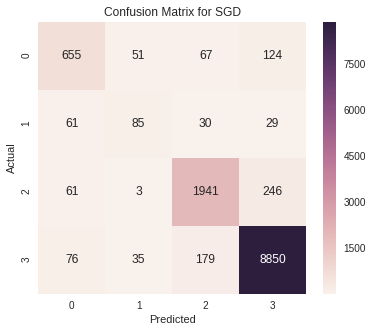

In [220]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = sgd.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix for SGD')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [221]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

             precision    recall  f1-score   support

  unrelated       0.77      0.73      0.75       897
      agree       0.49      0.41      0.45       205
   disagree       0.88      0.86      0.87      2251
    discuss       0.96      0.97      0.96      9140

avg / total       0.92      0.92      0.92     12493



# Gradiant Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(verbose=True).fit(X_train, y_train)

print('Accuracy of Gradient Boosting classifier on training set: {:.4f}' .format(logreg.score(X_train, y_train)))
print('Accuracy of Gradient Boosting classifier on test set: {:.4f}' .format(logreg.score(X_test, y_test)))

# MultiLayer Perceptron

In [45]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(verbose=True).fit(X_train, y_train)

Iteration 1, loss = 0.66931392
Iteration 2, loss = 0.47774930
Iteration 3, loss = 0.43698050
Iteration 4, loss = 0.40888575
Iteration 5, loss = 0.38315539
Iteration 6, loss = 0.35924128
Iteration 7, loss = 0.33531526
Iteration 8, loss = 0.31248813
Iteration 9, loss = 0.28911678
Iteration 10, loss = 0.26787853
Iteration 11, loss = 0.24777348
Iteration 12, loss = 0.22825789
Iteration 13, loss = 0.21034291
Iteration 14, loss = 0.19511470
Iteration 15, loss = 0.18136369
Iteration 16, loss = 0.16887260
Iteration 17, loss = 0.15756523
Iteration 18, loss = 0.14687826
Iteration 19, loss = 0.13741148
Iteration 20, loss = 0.12914854
Iteration 21, loss = 0.12138111
Iteration 22, loss = 0.11343920
Iteration 23, loss = 0.10938653
Iteration 24, loss = 0.10193712
Iteration 25, loss = 0.09781504
Iteration 26, loss = 0.09281389
Iteration 27, loss = 0.08924845
Iteration 28, loss = 0.08532757
Iteration 29, loss = 0.08066088
Iteration 30, loss = 0.07783541
Iteration 31, loss = 0.07510243
Iteration 32, los

In [10]:
predicted = clf.predict(X_test[9])
print(predicted)

['unrelated']


In [11]:
print(predicted == y_test[9])

[ True]


In [47]:
print('Accuracy of MLP on training set: {:.4f}' .format(clf.score(X_train, y_train)))
print('Accuracy of MLP on test set: {:.4f}' .format(clf.score(X_test, y_test)))

Accuracy of MLP on training set: 0.9931
Accuracy of MLP on test set: 0.9286


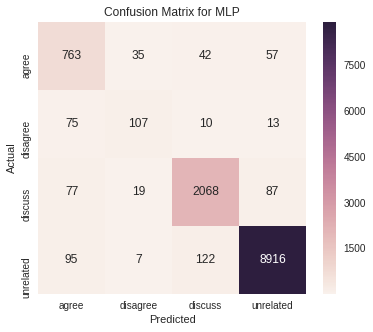

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['agree', 'disagree', 'discuss', 'unrelated'], yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.title('Confusion Matrix for MLP')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

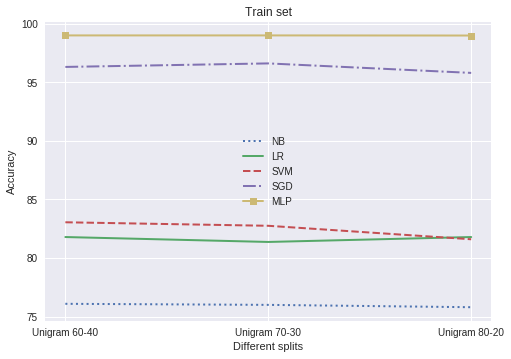

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = [76.09, 76.00,	75.80]
b = [81.79,	81.37,	81.79]
c = [83.05,	82.75,	81.60]
d = [96.31,	96.61,	95.80]
e = [99,	99,	98.99]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Train set')
plt.xticks([0,1,2,3],['Unigram 60-40', 'Unigram 70-30', 'Unigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()

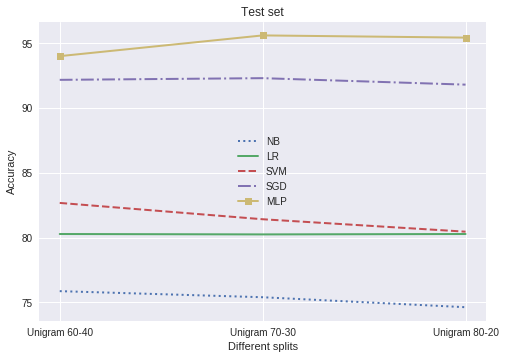

In [1]:
#testing
import numpy as np
import matplotlib.pyplot as plt

a = [75.86, 75.39, 74.62]
b = [80.27, 80.24, 80.27]
c = [82.67, 81.41, 80.45]
d = [92.17, 92.30, 91.80]
e = [94, 95.6, 95.43]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Test set')
plt.xticks([0,1,2,3],['Unigram 60-40', 'Unigram 70-30', 'Unigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()

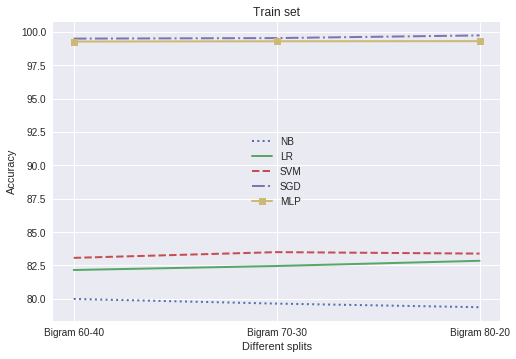

In [4]:
#Bigram Train
import numpy as np
import matplotlib.pyplot as plt

a = [79.99, 79.64, 79.37]
b = [82.16,	82.46, 82.85]
c = [83.07,	83.50, 83.39]
d = [99.51,	99.55, 99.75]
e = [99.29,	99.31, 99.32]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Train set')
plt.xticks([0,1,2,3],['Bigram 60-40', 'Bigram 70-30', 'Bigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()


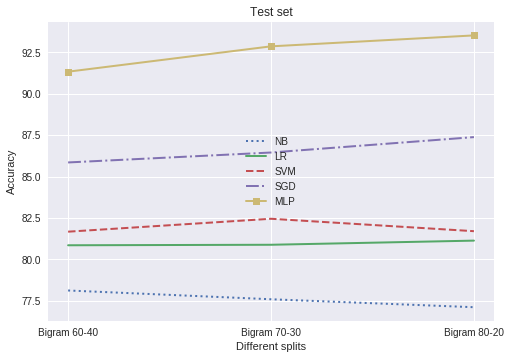

In [3]:
#Bigram Test
import numpy as np
import matplotlib.pyplot as plt

a = [78.12,	77.59, 77.11]
b = [80.85,	80.88, 81.13]
c = [81.67,	82.45, 81.70]
d = [85.85,	86.45, 87.38]
e = [91.33, 92.86, 93.52]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Test set')
plt.xticks([0,1,2,3],['Bigram 60-40', 'Bigram 70-30', 'Bigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()